In [ ]:
# Required for Google Colab!

!pip install rasterio
!pip install xarray
!pip install zarr
!pip install attention

from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/MyDrive/Project/Models')  # Zach
# os.chdir('/content/drive/MyDrive/SYDE 675/Project/Models/')  # Nishad

In [5]:
import os
import math
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy import stats
import datetime
from itertools import product

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import concatenate, Permute, Dense, Dropout, LSTM
from keras.constraints import maxnorm, nonneg
from tensorflow.keras.constraints import MinMaxNorm, Constraint, UnitNorm
from keras import backend
from keras.regularizers import L1L2

from attention import Attention

## Read and pre-process data

In [7]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1s3HtSi9JoXwirETZIlYRsAwmdx2QEtt9/Project/Models'

In [28]:
def window_mean(arr, num_steps, axis=1):
    """Take  mean over a (non-rolling) window using a specified number of steps"""
    assert num_steps < arr.shape[axis], f'num_steps ({num_steps}) must be a smaller than the length of the specified axis ({arr.shape[axis]})'
    assert arr.shape[axis] % num_steps == 0, f'num_steps must be a factor of the length of the specified axis ({arr.shape[axis]})'
    assert isinstance(num_steps, int), 'num_steps must be an integer'
    return np.array(np.split(arr, num_steps, axis=axis)).mean(axis=0).astype(np.float32)

def pull_apart(arr, lengths, axis=1):
    """Split array using the desired lengths. Lengths should add to the length of the array."""
    return np.split(arr, np.cumsum(lengths)[:-1], axis=axis)

def month_to_30(arr):
    """Transorm uneven calendar months to 30-days (from Ali et al.)"""
    if len(arr) > 30:
        return list(arr[:30])
    elif len(arr) < 30:
        return list(arr) + [arr[-1]] * (30 - len(arr))
    else:
        return list(arr)
    
def get_daily_range():
    """Get a datetime index from 1979 to 2019"""
    tmp = pd.DataFrame(index=pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2018, 12, 31), freq='D'))
    tmp['month'] = [dt.month for dt in tmp.index]
    tmp['year'] = [dt.year for dt in tmp.index]
    daily_range = [month_to_30(arr.index) for month, arr in tmp.groupby(['year', 'month'])]
    return pd.DatetimeIndex(np.array(daily_range).flatten())

# Read input datasets from Ali et al.
daily_data = np.load('../Data/dailyt30_features.npy', allow_pickle=True)
monthly_data = np.load('../Data/monthly_features.npy', allow_pickle=True)
daily_target = np.load('../Data/dailyt30_target.npy', allow_pickle=True)
monthly_target = np.load('../Data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')
daily_range = get_daily_range()

# Choose whether to deseasonalize
deseasonalize_X = True

# Note that this removes climatologies based on ALL data. In prod would need to only be training set
if deseasonalize_X:
    # Daily
    for i in range(daily_data.shape[-1]):
        shape = daily_data[:, :, i].shape
        tmp = xr.DataArray(daily_data[:, :, i].flatten(), dims=['time'], coords={'time': daily_range})
        climatologies = tmp.groupby('time.month').mean()
        daily_data[:, :, i] = (tmp.groupby('time.month') - climatologies).values.reshape(shape)
        
    # Monthly
    for i in range(monthly_data.shape[-1]):
        shape = monthly_data[:, :, i].shape
        tmp = xr.DataArray(monthly_data[:, :, i].flatten(), dims=['time'], coords={'time': month_range})
        climatologies = tmp.groupby('time.month').mean()
        monthly_data[:, :, i] = (tmp.groupby('time.month') - climatologies).values.reshape(shape)
        


# Specify temporal scales
# Note that these must be factors of 30...
data = [
    daily_data,  # 1day
    window_mean(daily_data, 3),  # 3day
    window_mean(daily_data, 10),  # 10day
    window_mean(daily_data, 15),  # 15day
    monthly_data,  # 1mo (30day)
]

# Concatenate datasets and save lengths to pull them apart later
scales = [d.shape[1] for d in data]
data = np.concatenate(data, axis=1)

# Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]
month_range = month_range[lag:]


# Manually set train and test ranges
train_dates = (datetime.datetime(1979, 1, 1), datetime.datetime(2013, 1, 1))
train_idx = (np.argwhere(month_range >= train_dates[0])[0][0], np.argwhere(month_range < train_dates[1])[-1][0])

test_dates = (datetime.datetime(2013, 1, 1), datetime.datetime(2018, 1, 1))
test_idx = (np.argwhere(month_range >= test_dates[0])[0][0], np.argwhere(month_range < test_dates[1])[-1][0])

x_train = data[train_idx[0]:train_idx[1]]
y_train = monthly_target[train_idx[0]:train_idx[1]]
month_range_train = month_range[train_idx[0]:train_idx[1]]
x_test = data[test_idx[0]:test_idx[1]]
y_test = monthly_target[test_idx[0]:test_idx[1]]
month_range_test = month_range[test_idx[0]:test_idx[1]]

# Save copy of y's that will not be de-trended
y_test_raw, y_train_raw = copy.deepcopy(y_test), copy.deepcopy(y_train)

Text(0.5, 1.0, 'SIE')

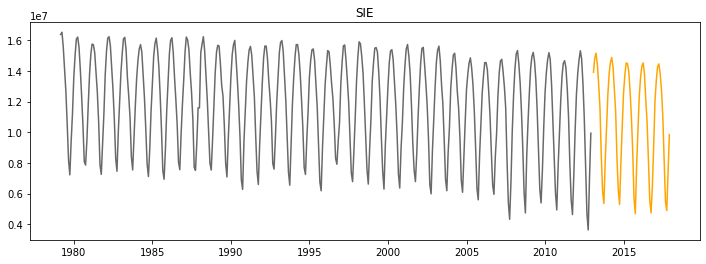

In [29]:
# Plot the original data
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('SIE')

Text(0.5, 1.0, 'Deseasonalized SIE')

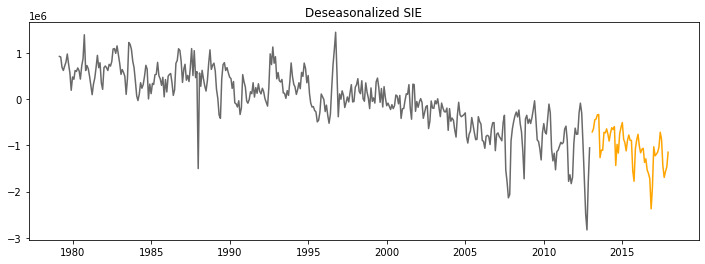

In [30]:
# Deseasonalize the SIE values by subtracting the average monthly SIE of the training dataset from both the train and test sets.
def deseasonalize(y_train, y_test, y_train_dates, y_test_dates):
    y_train = xr.DataArray(y_train, dims=['time'], coords={'time': y_train_dates})
    y_test = xr.DataArray(y_test, dims=['time'], coords={'time': y_test_dates})

    climatologies = y_train.groupby('time.month').mean()
    y_train = (y_train.groupby('time.month') - climatologies).values
    y_test = (y_test.groupby('time.month') - climatologies).values
    return y_train, y_test

y_train, y_test = deseasonalize(y_train, y_test, month_range_train, month_range_test)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('Deseasonalized SIE')

We can clearly see a negative trend in the data, which should also be removed (likely an effect of climate change). Again the trend is found using the train set only, and applied to both train and test sets.

Text(0.5, 1.0, 'Deseasonalized and de-trended SIE')

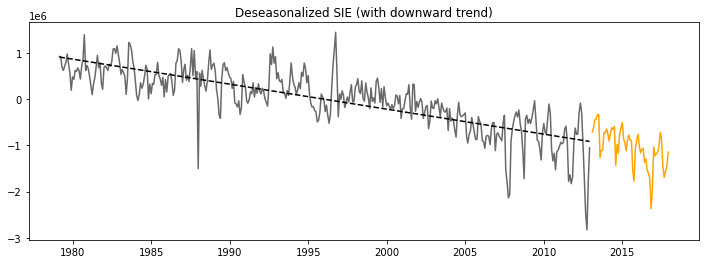

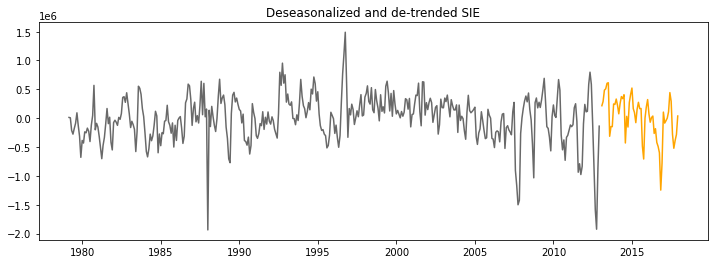

In [31]:
slope, intercept, r, p, se = stats.linregress(month_range_train.view(int), list(y_train))

# Plot with trend
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.plot(month_range_train, intercept + slope * month_range_train.view(int), 'k--')
plt.title('Deseasonalized SIE (with downward trend)')

# Remove trend
def detrend(y_train, y_test, y_train_dates, y_test_dates):
    slope, intercept, r, p, se = stats.linregress(month_range_train.view(int), list(y_train))
    y_train = np.array(y_train - (intercept + slope * month_range_train.view(int)))
    y_test = np.array(y_test - (intercept + slope * month_range_test.view(int)))
    return y_train, y_test

y_train, y_test = detrend(y_train, y_test, month_range_train, month_range_test)
    
# Plot without trend
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('Deseasonalized and de-trended SIE')

## Define baseline models

Test RMSE: 368,854.5
Test NRMSE: 3.42%
Test R_Square: 0.988


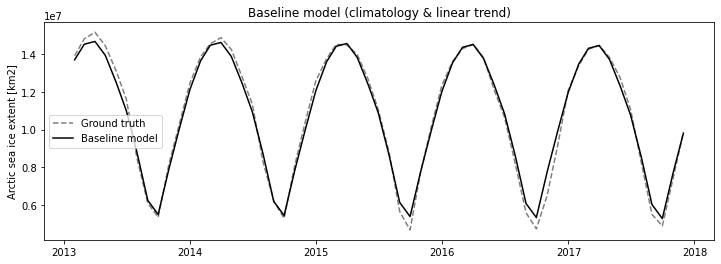

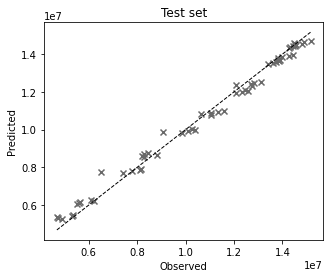

In [36]:
class Climatology:
    def __init__(self):
        self.climatologies = None
        self.slope = None
        self.intercept = None
    
    def fit(self, X, y):
        y = xr.DataArray(y, dims=['time'], coords={'time': X})
        climatologies = y.groupby('time.month').mean()
        
        # Remove climatology to perform linreg
        y = y.groupby('time.month') - climatologies  
        slope, intercept, r, p, se = stats.linregress(X.view(int), y)
        
        self.slope = slope
        self.intercept = intercept
        self.climatologies = climatologies
        
    def predict(self, X):
        pred_y = xr.DataArray(np.zeros(shape=len(X)), dims=['time'], coords={'time': X}).groupby('time.month') + self.climatologies
        pred_y = pred_y + self.intercept + self.slope * X.view(int)
        return pred_y

class Persistence:
    def __init__(self):
        pass
        
    def predict(self, X):
        return X[1:] + X[-1:]

# Plot the original data and baseline model
baseline_model = Climatology()
baseline_model.fit(month_range_train, list(y_train_raw))
baseline_pred = baseline_model.predict(month_range_test)

plt.figure(figsize=(12, 4))
plt.plot(month_range_test, y_test_raw, c='gray', ls='--', label='Ground truth')
plt.plot(month_range_test, baseline_pred, c='k', label='Baseline model')
plt.ylabel('Arctic sea ice extent [km2]')
plt.title('Baseline model (climatology & linear trend)')
plt.legend()

# RMSE
rmse = math.sqrt(mean_squared_error(y_test_raw, baseline_pred))

# NRMSE
nrmse = rmse /(y_test_raw.mean()) 

# R2
r_sq = r2_score(y_test_raw, baseline_pred)

print(f'Test RMSE: {rmse:,.1f}')
print(f'Test NRMSE: {nrmse*100:.2f}%')
print(f'Test R_Square: {r_sq:.3f}')

plt.figure(figsize=(5, 4))
plt.scatter(y_test_raw, baseline_pred, c='dimgrey', marker='x')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'k--', lw=1)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Test set')

plt.show()

# Create and train model

Converted from shape (18676, 11) to shape (406, 46, 11)
Converted from shape (2714, 11) to shape (59, 46, 11)
Epoch 1/500
17/17 [==============================] - 38s 522ms/step - loss: 6.7084 - val_loss: 7.6271
Epoch 2/500
17/17 [==============================] - 1s 86ms/step - loss: 5.6747 - val_loss: 6.6253
Epoch 3/500
17/17 [==============================] - 1s 85ms/step - loss: 4.7865 - val_loss: 5.8185
Epoch 4/500
17/17 [==============================] - 1s 85ms/step - loss: 4.0046 - val_loss: 5.2707
Epoch 5/500
17/17 [==============================] - 1s 85ms/step - loss: 3.3187 - val_loss: 4.5668
Epoch 6/500
17/17 [==============================] - 1s 86ms/step - loss: 2.7606 - val_loss: 4.1839
Epoch 7/500
17/17 [==============================] - 1s 87ms/step - loss: 2.2570 - val_loss: 3.7586
Epoch 8/500
17/17 [==============================] - 1s 85ms/step - loss: 1.8743 - val_loss: 3.4446
Epoch 9/500
17/17 [==============================] - 1s 87ms/step - loss: 1.5877 - val_l

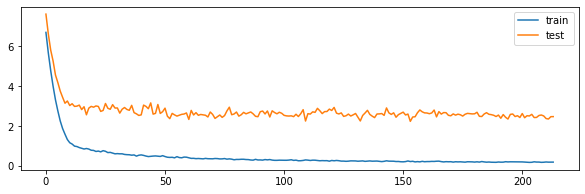

In [45]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Remove if you want to use GPU

# Note that we change some of the original architecture from Ali et al. in order to improve performance
# Increae number of LSTM layers and filters, regularization, and additional timescales.
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

timesteps = x_train.shape[1]

# Normalize the features, requires reshaping to 2D (?)
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2]))
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1))
y_test = scaler_l.transform(y_test.reshape(-1,1))

# Revert it back to 3D
x_train = reshape_features(x_train, timesteps)
x_test = reshape_features(x_test, timesteps)

# Build ensemble model
num_features = 11

# Loop over each time scale (e.g. 1, 3, 10, 15, 30)
models = []
models_inputs = []
for num_days in scales:
    model_input= Input(shape=(num_days, num_features))
    
    model = Permute((2,1), input_shape=(num_days, num_features))(model_input)
    model = LSTM(64, return_sequences=True, dropout=0.2, kernel_regularizer=L1L2(0.001, 0.001))(model)
    model = LSTM(32, return_sequences=True, dropout=0.2, kernel_regularizer=L1L2(0.001, 0.001))(model)
    model = LSTM(16, return_sequences=True, dropout=0.2, kernel_regularizer=L1L2(0.001, 0.001))(model)
    model = Attention()(model)
    model = Dense(1)(model)
    
    models_inputs.append(model_input)
    models.append(model)

ensemble = concatenate(models)
merged_model = Dense(1)(ensemble)
model = Model(inputs=models_inputs, outputs=merged_model, name='EALSTM')

#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

# Model x input is a list of arrays corresponding to each timeframe, so split the concatenated dataset into its parts
x_train_sets = pull_apart(x_train, scales, axis=1)
x_train_sets = [d.astype('float32') for d in x_train_sets]

x_test_sets = pull_apart(x_test, scales, axis=1)
x_test_sets = [d.astype('float32') for d in x_test_sets]

history=model.fit(
    x_train_sets,
    y_train,
    epochs=500,
    batch_size=20,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=keras_callbacks)

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 11296211.7
Test NRMSE: 1.0462
Test R_Square: -0.544


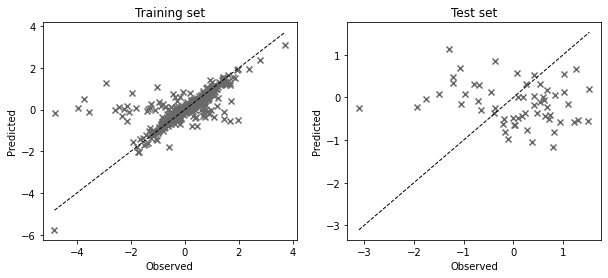

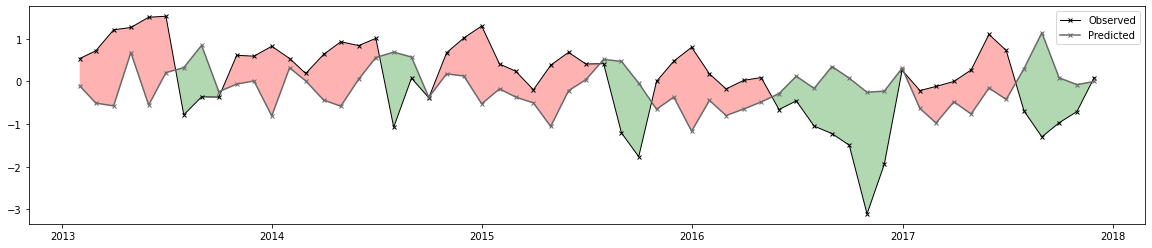

In [46]:
# Predict
pred_train = model.predict(x_train_sets)
pred_test = model.predict(x_test_sets)

# Inverse the transforms
pred_train_inv = scaler_l.inverse_transform(pred_train)
pred_test_inv = scaler_l.inverse_transform(pred_test)
y_test_inv = y_test_raw
y_train_inv = y_train_raw

# RMSE
rmse = math.sqrt(mean_squared_error(y_test_inv, pred_test_inv))

# NRMSE
y_max = y_test_inv.max()
y_min = y_test_inv.min()
nrmse = rmse /(y_test_inv.mean()) 

# R2
r_sq = r2_score(y_test, pred_test)

print(f'Test RMSE: {rmse:.1f}')
print(f'Test NRMSE: {nrmse:.4f}')
print(f'Test R_Square: {r_sq:.3f}')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(y_train, pred_train, c='dimgrey', marker='x')
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training set')

axs[1].scatter(y_test, pred_test, c='dimgrey', marker='x')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Test set')

plt.show()

def plot_timeseries(ypred, ytrue, daterange):
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(daterange, ytrue, label='Observed', color='k', ls='-', lw=1, marker='x', markersize=4)
    ax.plot(daterange, ypred, label='Predicted', color='dimgrey', lw=1.5, marker='x', markersize=4)
    ax.fill_between(daterange, ytrue, ypred, where=(ypred<=ytrue), facecolor='red', alpha=0.3, interpolate=True)
    ax.fill_between(daterange, ytrue, ypred, where=(ypred>=ytrue), facecolor='green', alpha=0.3, interpolate=True)
    plt.legend()
    return fig, ax

plot_timeseries(pred_test.flatten(), y_test.flatten(), month_range_test)
plt.show()

## We see that the model does not generalize at all. No combination of LSTM layers & regularization fixed this in our trials.

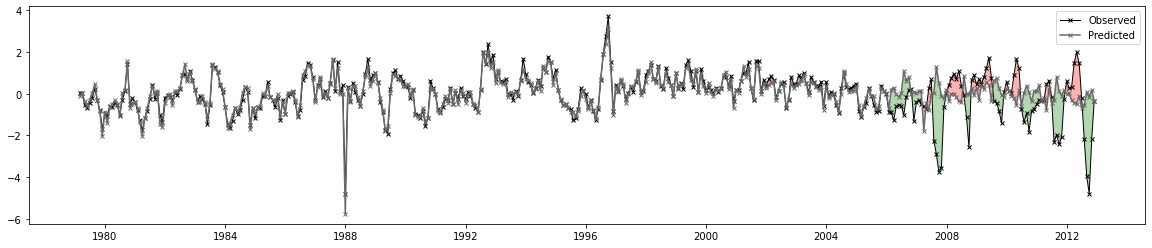

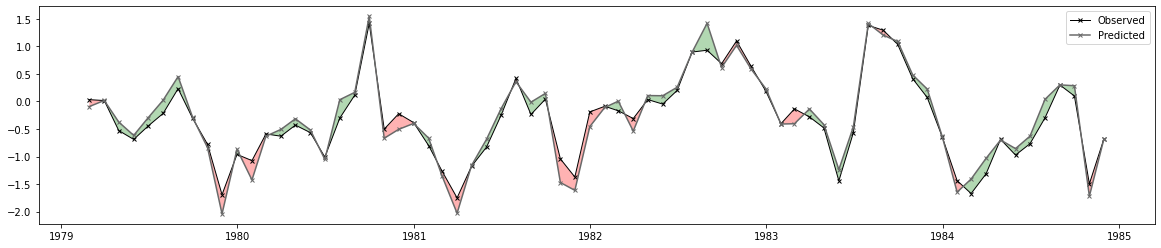

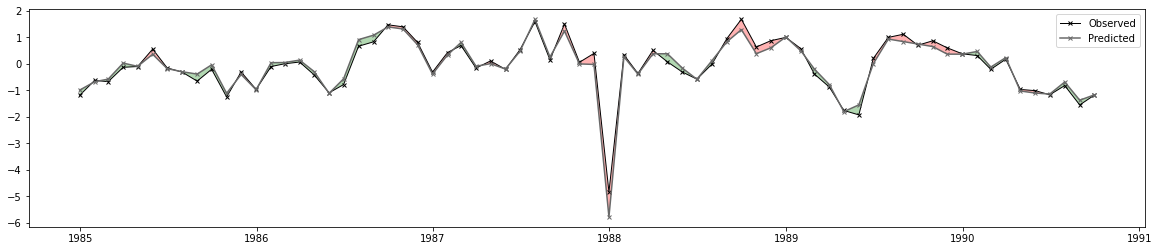

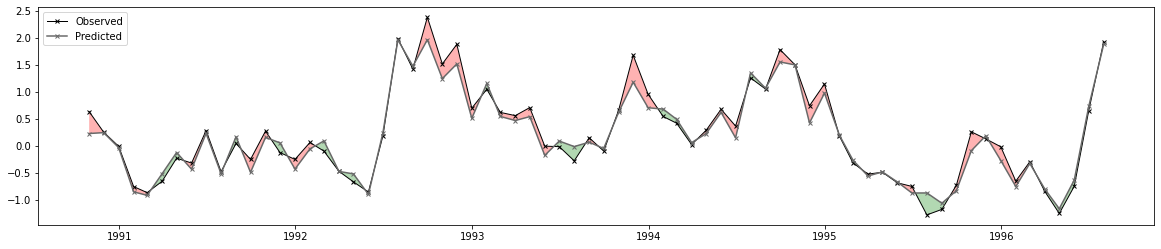

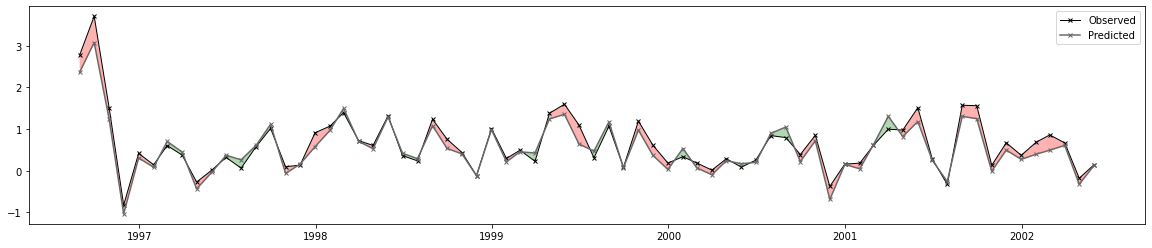

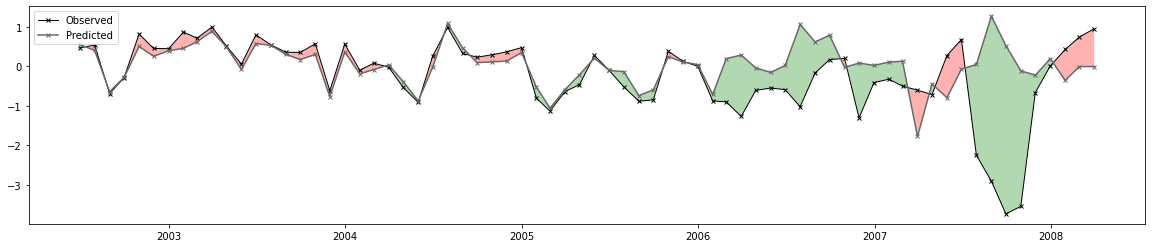

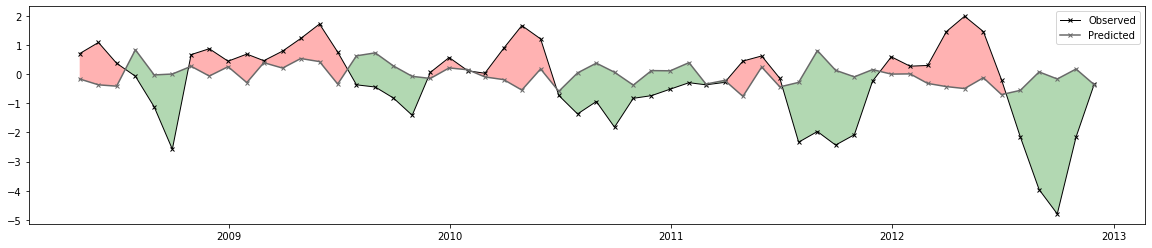

In [47]:
# Plot full timeseries
plot_timeseries(pred_train.flatten(), y_train.flatten(), month_range_train)

# Plot timeseries in parts
i_start = i_end = 0
while i_end < len(pred_train):
    i_end = min(i_start + 70, len(pred_train))
    plot_timeseries(pred_train.flatten()[i_start:i_end], y_train.flatten()[i_start:i_end], month_range_train[-len(pred_train):][i_start:i_end])
    plt.show()
    i_start =i_end